In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import torch.nn.functional as F

import numpy as np

import os
import time

In [2]:
data_path = "/scratch/joluseti/local_datasets"

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with the MNIST mean and std
])


train_data = datasets.MNIST(root=data_path, train=True, download=False, transform=transform)
test_data = datasets.MNIST(root=data_path, train=False, download=False, transform=transform)


BATCH_SIZE = 256

train_loader = DataLoader(dataset=train_data, batch_size=256, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
class QuantLenet(nn.Module):
    def __init__(self):
        super().__init__()

        self.quant = torch.ao.quantization.QuantStub()

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5, bias=False)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2) 
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, bias=False)
        self.fc1 = nn.Linear(in_features = 16 * 4 * 4, out_features = 120, bias = False)
        self.fc2 = nn.Linear(in_features = 120, out_features = 84, bias=False)
        self.fc3 = nn.Linear(in_features = 84, out_features = 10, bias=False)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        
        self.dequant = torch.ao.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.relu1(self.conv1(x))
        x = self.pool(x)
        x = self.relu2(self.conv2(x))
        x = self.pool(x)
        y = x.reshape(-1, 16 * 4 * 4)
        x = x.reshape(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.dequant(x)

        return x, y

In [30]:
def load_model(model_file):
    #model = QuantLenet()
    model = torch.load(model_file, weights_only=False)
    #model.load_state_dict(state_dict)
    model.to('cpu')
    return model

def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

In [31]:
def evaluate(model, data_loader):
    device = "cpu"        
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:

            images = images.to(device)
            labels = labels.to(device)
            
            outputs, _ = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


def calibrate(model, data_loader, cal_batch_sz = 10):
    model.eval()
    print("Calibration Start...")
    with torch.no_grad():
        for data, _ in data_loader:  # Pass some sample data
            model(data)
            cal_batch_sz -= 1
            if cal_batch_sz == 0:
                break
    print("Calibration Done...")

In [32]:
model_path = '/scratch/joluseti/618/model/float_model.pth'

In [33]:
torch.serialization.add_safe_globals([QuantLenet()])

In [34]:
float_model = load_model(model_path).to('cpu')
float_model.eval()

QuantLenet(
  (quant): QuantStub()
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (fc1): Linear(in_features=256, out_features=120, bias=False)
  (fc2): Linear(in_features=120, out_features=84, bias=False)
  (fc3): Linear(in_features=84, out_features=10, bias=False)
  (relu1): ReLU()
  (relu2): ReLU()
  (dequant): DeQuantStub()
)

In [35]:
modules_to_fuse = [[f'conv{i}', f'relu{i}'] for i in range(1, 3)]
modules_to_fuse

[['conv1', 'relu1'], ['conv2', 'relu2']]

In [36]:
quant_model = torch.ao.quantization.fuse_modules(float_model, modules_to_fuse)
quant_model.eval()

QuantLenet(
  (quant): QuantStub()
  (conv1): ConvReLU2d(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (1): ReLU()
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): ConvReLU2d(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (1): ReLU()
  )
  (fc1): Linear(in_features=256, out_features=120, bias=False)
  (fc2): Linear(in_features=120, out_features=84, bias=False)
  (fc3): Linear(in_features=84, out_features=10, bias=False)
  (relu1): Identity()
  (relu2): Identity()
  (dequant): DeQuantStub()
)

In [37]:
print_size_of_model(float_model)
print(f"Test Accuracy: {evaluate(float_model, test_loader):.2f}%")

Size (MB): 0.178993
Test Accuracy: 98.54%


In [38]:
print_size_of_model(quant_model)
print(f"Test Accuracy: {evaluate(quant_model, test_loader):.2f}%")

Size (MB): 0.179057
Test Accuracy: 98.54%


In [39]:
torch.backends.quantized.engine = 'qnnpack'
quant_model.qconfig = torch.ao.quantization.get_default_qconfig('qnnpack')
torch.ao.quantization.prepare(quant_model, inplace=True)
calibrate(quant_model, train_loader, cal_batch_sz = 40)
torch.ao.quantization.convert(quant_model, inplace=True)
quant_model.eval()

Calibration Start...
Calibration Done...


QuantLenet(
  (quant): Quantize(scale=tensor([0.0127]), zero_point=tensor([33]), dtype=torch.quint8)
  (conv1): QuantizedConvReLU2d(1, 6, kernel_size=(5, 5), stride=(1, 1), scale=0.027164967730641365, zero_point=0)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): QuantizedConvReLU2d(6, 16, kernel_size=(5, 5), stride=(1, 1), scale=0.04062113165855408, zero_point=0)
  (fc1): QuantizedLinear(in_features=256, out_features=120, scale=0.1486314982175827, zero_point=135, qscheme=torch.per_tensor_affine)
  (fc2): QuantizedLinear(in_features=120, out_features=84, scale=0.12291006743907928, zero_point=114, qscheme=torch.per_tensor_affine)
  (fc3): QuantizedLinear(in_features=84, out_features=10, scale=0.17384813725948334, zero_point=142, qscheme=torch.per_tensor_affine)
  (relu1): Identity()
  (relu2): Identity()
  (dequant): DeQuantize()
)

In [41]:
print_size_of_model(quant_model)
#print(f"Test Accuracy: {evaluate(quant_model, test_loader):.2f}%")

Size (MB): 0.05191


In [42]:
torch.jit.save(torch.jit.script(float_model), '/scratch/joluseti/618/test/float.pth')
torch.jit.save(torch.jit.script(quant_model), '/scratch/joluseti/618/test/quant.pth')

In [24]:
torch.ao.quantization.get_default_qconfig("qnnpack")

QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=False){}, weight=functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric){})

In [25]:
print(torch.ao.quantization.get_default_qconfig("x86"))

QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})


## Load Quantized model 

In [26]:
model = torch.jit.load('/scratch/joluseti/618/test/quant.pth')

In [27]:
x = torch.randn((1,1,28,28))
model(x)

(tensor([[-1.3729, -0.8581,  0.3432,  3.0890, -2.5742,  0.1716, -3.6039,  0.0000,
           1.2013, -0.3432]]),
 tensor([[0.3714, 0.0000, 1.0728, 0.1651, 0.3714, 0.0000, 0.6602, 0.4952, 0.0825,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0316, 0.0000, 0.2476, 0.2888,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0413, 0.0413, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.6190, 1.1554, 0.0000, 0.4126, 0.7015, 0.3301, 0.0000,
          0.0825, 0.4952, 0.7840, 1.3204, 0.0000, 0.0000, 0.0000, 0.3301, 0.2888,
          0.7840, 1.0316, 1.1554, 0.2888, 0.6190, 0.8665, 0.1238, 0.7840, 0.0000,
          0.3301, 0.1238, 0.0000, 0.2063, 0.9078, 0.7015, 0.7015, 0.4539, 0.0000,
          0.0000, 1.7331, 1.6918, 1.4030, 2.3520, 0.9078, 2.0632, 2.1044, 2.3520,
          2.6821, 2.2695, 1.8156, 1.4030, 2.1870, 2.3933, 3.3011, 3.6312, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0

## Code to see output in different layers

In [45]:
import copy

view_model = copy.deepcopy(quant_model)

In [46]:
# Assuming 'quant_model' is your loaded quantized model
quant_model.eval()  # Set the model to evaluation mode

# Dictionary to store outputs
layer_outputs = {}

# Define a hook function to capture outputs
def hook_fn(module, input, output):
    # Store the output of the layer
    layer_outputs[module] = output

# Attach the hook to each layer in the model
for name, module in view_model.named_modules():
    module.register_forward_hook(hook_fn)

# Example input (replace with the actual input for your model)
input_tensor = torch.randn(1, 1, 28, 28)  # Example: batch size 1, 1 channel, 28x28 image
input_tensor = input_tensor.to(torch.float32)  # Ensure input is float32 for quantization

# Perform a forward pass through the model
with torch.no_grad():
    view_model(input_tensor)

# Print the outputs for each layer
for layer, output in layer_outputs.items():
    print(f"Output of layer {layer}:{output.shape}")


Output of layer Quantize(scale=tensor([0.0127]), zero_point=tensor([33]), dtype=torch.quint8):torch.Size([1, 1, 28, 28])
Output of layer QuantizedConvReLU2d(1, 6, kernel_size=(5, 5), stride=(1, 1), scale=0.027150312438607216, zero_point=0):torch.Size([1, 6, 24, 24])
Output of layer Identity():torch.Size([1, 6, 24, 24])
Output of layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False):torch.Size([1, 16, 4, 4])
Output of layer QuantizedConvReLU2d(6, 16, kernel_size=(5, 5), stride=(1, 1), scale=0.04114341735839844, zero_point=0):torch.Size([1, 16, 8, 8])
Output of layer Identity():torch.Size([1, 16, 8, 8])
Output of layer QuantizedLinear(in_features=256, out_features=120, scale=0.1537804752588272, zero_point=137, qscheme=torch.per_tensor_affine):torch.Size([1, 120])
Output of layer QuantizedLinear(in_features=120, out_features=84, scale=0.12323486804962158, zero_point=116, qscheme=torch.per_tensor_affine):torch.Size([1, 84])
Output of layer QuantizedLinear(in_feat

In [47]:
for m in layer_outputs.keys():
    print(m)

Quantize(scale=tensor([0.0127]), zero_point=tensor([33]), dtype=torch.quint8)
QuantizedConvReLU2d(1, 6, kernel_size=(5, 5), stride=(1, 1), scale=0.027150312438607216, zero_point=0)
Identity()
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
QuantizedConvReLU2d(6, 16, kernel_size=(5, 5), stride=(1, 1), scale=0.04114341735839844, zero_point=0)
Identity()
QuantizedLinear(in_features=256, out_features=120, scale=0.1537804752588272, zero_point=137, qscheme=torch.per_tensor_affine)
QuantizedLinear(in_features=120, out_features=84, scale=0.12323486804962158, zero_point=116, qscheme=torch.per_tensor_affine)
QuantizedLinear(in_features=84, out_features=10, scale=0.17416171729564667, zero_point=142, qscheme=torch.per_tensor_affine)
DeQuantize()
QuantLenet(
  (quant): Quantize(scale=tensor([0.0127]), zero_point=tensor([33]), dtype=torch.quint8)
  (conv1): QuantizedConvReLU2d(1, 6, kernel_size=(5, 5), stride=(1, 1), scale=0.027150312438607216, zero_point=0)
  (pool): MaxP

In [42]:
quant_model.quant

Quantize(scale=tensor([0.0127]), zero_point=tensor([33]), dtype=torch.quint8)

In [31]:
quant_model.conv1.weight().int_repr()

tensor([[[[  32,   41,   -5,  -45,   60],
          [ -28,   57,  -10,    1,   68],
          [  88,   17,  -74,  -68,   61],
          [  31,   41,  -57,  -98,  -34],
          [  10,   36,   51,    4,   40]]],


        [[[ -49,  -27,  -16,   27,   19],
          [ -87,  -16,   86,  -15,   -5],
          [ -57,  -78,   80,   51,    0],
          [ -47,  -56,   92,   17,  -26],
          [-114,   -1,   41,   75,  -16]]],


        [[[ -14,   50,  -28,   46,  -21],
          [ -46,   40,   73,   41,   56],
          [  64,   73,  -45,  -18,   24],
          [ -51,   11,   51,   93,   43],
          [  51,   44,  -58,   43,   79]]],


        [[[  48,   40,   97,   80,   76],
          [  63,  -16,  -29,   48,   66],
          [ -15,   48,  -92,  -26,   54],
          [ -38,  -73,  -18,  -99,  -23],
          [ -84,  -25,    9,  -64,  -42]]],


        [[[ -41,   87,   38,   -5,   12],
          [   6,   34,   76,   -8,  -77],
          [  11,   19,   80,   55,  -34],
          [  -8,  

## Basic Benchmark

In [33]:
def run_benchmark(model_file, img_loader):
    elapsed = 0
    model = torch.jit.load(model_file)
    model.eval()
    num_batches = 1
    # Run the scripted model on a few batches of images
    for i, (images, target) in enumerate(img_loader):
        if i < num_batches:
            start = time.time()
            output = model(images)
            end = time.time()
            elapsed = elapsed + (end-start)
        else:
            break
    num_images = images.size()[0] * num_batches

    print(f'Elapsed time: {elapsed/num_images*1000} ms' )
    return elapsed

In [35]:
run_benchmark('/scratch/joluseti/618/test/float.pth', test_loader)

Elapsed time: 0.03268010914325714 ms


0.008366107940673828

In [36]:
run_benchmark('/scratch/joluseti/618/test/quant.pth', test_loader)

Elapsed time: 8.926535956561565 ms


2.2851932048797607

## Save Model Params

In [27]:
for name, module in quant_model.named_modules():
    print(name, dir(module))

 ['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__overloads__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_compiled_call_impl', '_forward_hooks', '_forward_hooks_always_called', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '_register_load_

In [28]:
for name, module in quant_model.named_modules():
    if hasattr(module, 'scale'):
        print(f"Module '{name}' has a weight method.")
        #print(module.weight().int_repr().min())
        print(module.zero_point)
        

Module 'quant' has a weight method.
tensor([33])
Module 'conv1' has a weight method.
0
Module 'conv2' has a weight method.
0
Module 'fc1' has a weight method.
136
Module 'fc2' has a weight method.
115
Module 'fc3' has a weight method.
142


In [29]:
for name, module in quant_model.named_modules():
    if hasattr(module, 'scale'):
        print(f"Module '{name}' has a weight method.")
        #print(module.weight().int_repr().min())
        print(module.scale)

Module 'quant' has a weight method.
tensor([0.0127])
Module 'conv1' has a weight method.
0.027446914464235306
Module 'conv2' has a weight method.
0.04141329973936081
Module 'fc1' has a weight method.
0.1510031670331955
Module 'fc2' has a weight method.
0.12524110078811646
Module 'fc3' has a weight method.
0.17506888508796692


In [36]:
quant_model.fc3.weight()

tensor([[ 0.0962,  0.0481, -0.0272, -0.0251, -0.0502,  0.0857,  0.0000, -0.0188,
          0.0314, -0.1004,  0.1087, -0.0941,  0.1338,  0.0606,  0.0586,  0.0314,
          0.1192, -0.0167, -0.1066, -0.1066,  0.0125, -0.1004, -0.0293, -0.0816,
          0.0962,  0.1108, -0.1715, -0.0565,  0.0125, -0.1046, -0.0167, -0.0941,
         -0.0167, -0.0774, -0.0376,  0.0084,  0.0272, -0.0753, -0.0523, -0.1025,
          0.0648, -0.0481, -0.0084, -0.1087,  0.0565,  0.0836, -0.0146,  0.0669,
         -0.1297,  0.0857, -0.0251, -0.0293, -0.0376, -0.0606, -0.1777, -0.0230,
          0.0146, -0.1798, -0.0293,  0.0816, -0.0439, -0.0167, -0.1861, -0.1066,
          0.0230,  0.1046, -0.0209, -0.0669, -0.0836, -0.0983,  0.0335, -0.0125,
         -0.0397, -0.0983,  0.1422,  0.0544,  0.0000,  0.1380,  0.0314, -0.0795,
          0.0084, -0.0690,  0.0188, -0.0293],
        [ 0.1422,  0.0753, -0.0355, -0.0021,  0.0795,  0.0460, -0.0230,  0.0209,
          0.0272,  0.0920,  0.0669, -0.0376,  0.0314, -0.1840, 

In [97]:
import math

def float_to_fixed_point(value, total_bits, fractional_bits):
    """
    Converts a floating-point value to a fixed-point representation.

    Args:
        value: The floating-point value to convert.
        total_bits: The total number of bits in the fixed-point representation.
        fractional_bits: The number of fractional bits.

    Returns:
        A tuple containing:
        - The fixed-point representation as an integer.
        - The scaling factor used (2**fractional_bits).
    """
    scaling_factor = 2**fractional_bits
    # Scale the value
    scaled_value = value * scaling_factor

    # Handle rounding (round to nearest integer)
    rounded_value = int(round(scaled_value))

    # Check for overflow
    max_value = (2**(total_bits - 1)) - 1
    min_value = -(2**(total_bits - 1))

    if rounded_value > max_value or rounded_value < min_value:
        raise OverflowError(f"Value {value} cannot be represented in Q{total_bits}.{fractional_bits} format.")
    
    # Clip the value to the range
    clipped_value = max(min(rounded_value, max_value), min_value)

    return clipped_value

In [38]:
def save_quantized_model_params_fpga(model, file_prefix):
    model_params = {}

    for name, module in model.named_modules():
        if hasattr(module, 'weight'):
            weight = module.weight().int_repr()
            weight_raw = module.weight().dequantize()
            weight_scale = module.weight().q_scale()
            scale = module.scale
            zero_point = module.zero_point

            #convert scale to fixed_point
            #scale_int = float_to_fixed_point(scale, total_bits = 16, fractional_bits = 4)

            model_params[f'{name}_weight'] = weight.detach().cpu().numpy().astype(np.int8)
            model_params[f'{name}_weight_raw'] = weight_raw.detach().cpu().numpy()
            model_params[f'{name}_weight_scale'] = weight_scale
            model_params[f'{name}_scale'] = scale
            model_params[f'{name}_zero_point'] = zero_point

            print(f"Module {name} params stored")
        
        elif hasattr(module, 'scale') and not hasattr(module, 'weight'):
            scale = module.scale.item()
            zero_point = module.zero_point.item()

            #convert scale to fixed_point
            #scale_int = float_to_fixed_point(scale, total_bits = 16, fractional_bits = 4)
            model_params[f'{name}_scale'] = scale
            model_params[f'{name}_zero_point'] = zero_point

            print(f"Module {name} params stored")

    # Save parameters as integers for FPGA use
    np.savez(f'{file_prefix}_fpga_quantized_params.npz', **model_params)
    return model_params

# Save the fixed-point parameters for FPGA
test_dict = save_quantized_model_params_fpga(quant_model, 'raw_quantized_model_fpga')

Module quant params stored
Module conv1 params stored
Module conv2 params stored
Module fc1 params stored
Module fc2 params stored
Module fc3 params stored


In [39]:
torch.save(test_dict, "parameters")

In [5]:
"""
def save_quantized_model_params_fpga(model, file_prefix):
    model_params = {}

    for name, module in model.named_modules():
        if isinstance(module, torch.nn.quantized.Conv2d):
            weight = module.weight().int_repr()
            bias = module.bias() if module.bias() is not None else None
            scale = module.scale
            zero_point = module.zero_point

            # Convert scale and zero-point to fixed-point
            scale_int, zero_point_int = save_fixed_point_params(scale, zero_point)

            model_params[f'{name}_weight'] = weight.detach().cpu().numpy().astype(np.int8)
            if bias is not None:
                model_params[f'{name}_bias'] = bias.detach().cpu().numpy().astype(np.int32)  # Bias may need 32-bit
            model_params[f'{name}_scale'] = scale_int
            model_params[f'{name}_zero_point'] = zero_point_int

        elif isinstance(module, torch.nn.quantized.Linear):
            weight = module.weight().int_repr()
            bias = module.bias() if module.bias() is not None else None
            scale = module.scale
            zero_point = module.zero_point

            scale_int, zero_point_int = save_fixed_point_params(scale, zero_point)

            model_params[f'{name}_weight'] = weight.detach().cpu().numpy().astype(np.int8)
            if bias is not None:
                model_params[f'{name}_bias'] = bias.detach().cpu().numpy().astype(np.int32)
            model_params[f'{name}_scale'] = scale_int
            model_params[f'{name}_zero_point'] = zero_point_int

    # Save parameters as integers for FPGA use
    np.savez(f'{file_prefix}_fpga_quantized_params.npz', **model_params)
    return model_params

# Save the fixed-point parameters for FPGA
test_dict = save_quantized_model_params_fpga(quant_model, 'quantized_model_fpga')
"""

"\ndef save_quantized_model_params_fpga(model, file_prefix):\n    model_params = {}\n\n    for name, module in model.named_modules():\n        if isinstance(module, torch.nn.quantized.Conv2d):\n            weight = module.weight().int_repr()\n            bias = module.bias() if module.bias() is not None else None\n            scale = module.scale\n            zero_point = module.zero_point\n\n            # Convert scale and zero-point to fixed-point\n            scale_int, zero_point_int = save_fixed_point_params(scale, zero_point)\n\n            model_params[f'{name}_weight'] = weight.detach().cpu().numpy().astype(np.int8)\n            if bias is not None:\n                model_params[f'{name}_bias'] = bias.detach().cpu().numpy().astype(np.int32)  # Bias may need 32-bit\n            model_params[f'{name}_scale'] = scale_int\n            model_params[f'{name}_zero_point'] = zero_point_int\n\n        elif isinstance(module, torch.nn.quantized.Linear):\n            weight = module.weigh

In [115]:
def scale_and_convert_to_q12_4(scale_factor, scaling_factor=4096):
  """Scales a scale factor and converts it to Q12.4 fixed-point format."""

  scaled_scale_factor = scale_factor * scaling_factor
  # Convert to Q12.4 (assuming a function float_to_fixed_point exists)
  scaled_scale_factor_q12_4 = float_to_fixed_point(scaled_scale_factor, 16, 4) 
  #17 total bits, 4 fractional bits
  return scaled_scale_factor_q12_4

# Example usage
original_scale_factor = 0.0127
scaling_factor = 4096  # 2^12

scaled_scale_factor_q12_4 = scale_and_convert_to_q12_4(original_scale_factor, scaling_factor=32)

print(f"Original scale factor: {original_scale_factor}")
print(f"Scaled scale factor (Q12.4): {scaled_scale_factor_q12_4}")
print(f"Binary representation: {bin(scaled_scale_factor_q12_4 & (2**16 -1))}") # Mask to get only 16 bits for display

Original scale factor: 0.0127
Scaled scale factor (Q12.4): 7
Binary representation: 0b111


In [40]:
test_dict

{'quant_scale': 0.012722019106149673,
 'quant_zero_point': 33,
 'conv1_weight': array([[[[  32,   41,   -5,  -45,   60],
          [ -28,   57,  -10,    1,   68],
          [  88,   17,  -74,  -68,   61],
          [  31,   41,  -57,  -98,  -34],
          [  10,   36,   51,    4,   40]]],
 
 
        [[[ -49,  -27,  -16,   27,   19],
          [ -87,  -16,   86,  -15,   -5],
          [ -57,  -78,   80,   51,    0],
          [ -47,  -56,   92,   17,  -26],
          [-114,   -1,   41,   75,  -16]]],
 
 
        [[[ -14,   50,  -28,   46,  -21],
          [ -46,   40,   73,   41,   56],
          [  64,   73,  -45,  -18,   24],
          [ -51,   11,   51,   93,   43],
          [  51,   44,  -58,   43,   79]]],
 
 
        [[[  48,   40,   97,   80,   76],
          [  63,  -16,  -29,   48,   66],
          [ -15,   48,  -92,  -26,   54],
          [ -38,  -73,  -18,  -99,  -23],
          [ -84,  -25,    9,  -64,  -42]]],
 
 
        [[[ -41,   87,   38,   -5,   12],
          [   6

## Convert to fixed point format

In [41]:
from pathlib import Path

In [42]:
for m in test_dict.keys():
    print(m)

quant_scale
quant_zero_point
conv1_weight
conv1_weight_raw
conv1_weight_scale
conv1_scale
conv1_zero_point
conv2_weight
conv2_weight_raw
conv2_weight_scale
conv2_scale
conv2_zero_point
fc1_weight
fc1_weight_raw
fc1_weight_scale
fc1_scale
fc1_zero_point
fc2_weight
fc2_weight_raw
fc2_weight_scale
fc2_scale
fc2_zero_point
fc3_weight
fc3_weight_raw
fc3_weight_scale
fc3_scale
fc3_zero_point


In [43]:
isinstance(test_dict["conv2_weight"], np.ndarray)

True

In [44]:
new_dict = test_dict

In [51]:
for m, n in new_dict.items():
    if isinstance(n, np.ndarray) and "raw" not in m:
        if(n.ndim > 2):
           n = n.reshape(n.shape[0], -1)
        print(m, n.shape)

conv1_weight (6, 25)
conv2_weight (16, 150)
fc1_weight (120, 256)
fc2_weight (84, 120)
fc3_weight (10, 84)


In [46]:
quant_model

QuantLenet(
  (quant): Quantize(scale=tensor([0.0127]), zero_point=tensor([33]), dtype=torch.quint8)
  (conv1): QuantizedConvReLU2d(1, 6, kernel_size=(5, 5), stride=(1, 1), scale=0.027446914464235306, zero_point=0)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): QuantizedConvReLU2d(6, 16, kernel_size=(5, 5), stride=(1, 1), scale=0.04141329973936081, zero_point=0)
  (fc1): QuantizedLinear(in_features=256, out_features=120, scale=0.1510031670331955, zero_point=136, qscheme=torch.per_tensor_affine)
  (fc2): QuantizedLinear(in_features=120, out_features=84, scale=0.12524110078811646, zero_point=115, qscheme=torch.per_tensor_affine)
  (fc3): QuantizedLinear(in_features=84, out_features=10, scale=0.17506888508796692, zero_point=142, qscheme=torch.per_tensor_affine)
  (relu1): Identity()
  (relu2): Identity()
  (dequant): DeQuantize()
)

In [47]:
folder_names = ["layer1", "layer3", "layer5", "layer6", "layer7"]
base_folder = "/scratch/joluseti/new_mif"


In [48]:
def float_to_q12_4(value):

    # Convert the float to the fixed-point representation with 4 fractional bits
    fixed_point_value = int(round(value * (1 << 4)))
    #print(fixed_point_value)

    # Format the value to 16 bits with leading zeros
    return format(fixed_point_value & 0xFFFF, '016b')

In [49]:
float_to_q12_4(-1)

'1111111111110000'

In [50]:
base_path = Path(base_folder)
base_path.mkdir(parents=True, exist_ok=True)

In [52]:
i = 0
for m, n in new_dict.items():
    if isinstance(n, np.ndarray) and "raw" not in m:
        if(n.ndim > 2):
           n = n.reshape(n.shape[0], -1)
        folder_path = base_path / folder_names[i]
        folder_path.mkdir(parents=True, exist_ok=True)

        for row_idx, row in enumerate(n):
            file_path = folder_path / f"{folder_names[i]}_weight{row_idx+1}.mif"
            #file_path.touch()
            #file_path.unlink()
            file_path.write_text("\n".join([str(float_to_q12_4(item)) for item in row]))
            
        print(f"{m} processed")
        i += 1



conv1_weight processed
conv2_weight processed
fc1_weight processed
fc2_weight processed
fc3_weight processed


In [53]:
import shutil

# Define the folder to zip and the output zip file
folder_to_zip = "example_folder"
output_zip = "example_folder_compressed"

# Create a zip archive
shutil.make_archive(base_folder, 'zip', base_folder)

print(f"Folder zipped as: {base_folder}.zip")

Folder zipped as: /scratch/joluseti/new_mif.zip


## Test

In [43]:
float_model

QuantLenet(
  (quant): QuantStub()
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (fc1): Linear(in_features=256, out_features=120, bias=False)
  (fc2): Linear(in_features=120, out_features=84, bias=False)
  (fc3): Linear(in_features=84, out_features=10, bias=False)
  (relu1): ReLU()
  (relu2): ReLU()
  (dequant): DeQuantStub()
)

In [44]:
quant_model

QuantLenet(
  (quant): Quantize(scale=tensor([0.0127]), zero_point=tensor([33]), dtype=torch.quint8)
  (conv1): QuantizedConvReLU2d(1, 6, kernel_size=(5, 5), stride=(1, 1), scale=0.027164967730641365, zero_point=0)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): QuantizedConvReLU2d(6, 16, kernel_size=(5, 5), stride=(1, 1), scale=0.04062113165855408, zero_point=0)
  (fc1): QuantizedLinear(in_features=256, out_features=120, scale=0.1486314982175827, zero_point=135, qscheme=torch.per_tensor_affine)
  (fc2): QuantizedLinear(in_features=120, out_features=84, scale=0.12291006743907928, zero_point=114, qscheme=torch.per_tensor_affine)
  (fc3): QuantizedLinear(in_features=84, out_features=10, scale=0.17384813725948334, zero_point=142, qscheme=torch.per_tensor_affine)
  (relu1): Identity()
  (relu2): Identity()
  (dequant): DeQuantize()
)

In [53]:
import matplotlib.pyplot as plt

In [94]:
float_weights = float_model.fc3.weight.detach().cpu().numpy()
#quant_weights = quant_model.fc1.weight().int_repr().detach().cpu().numpy()
quant_weights = quant_model.fc3.weight().dequantize().detach().cpu().numpy()

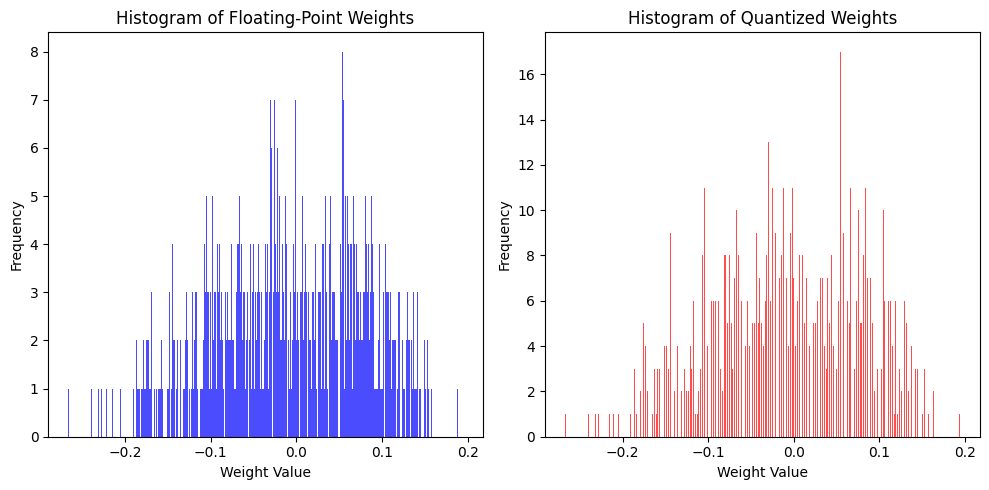

In [95]:
# Flatten the weights to make the histogram easier to plot
float_weights_flat = float_weights.flatten()
quant_weights_flat = quant_weights.flatten()

# Plot the histograms for comparison
plt.figure(figsize=(10, 5))

# Plot the histogram for floating-point weights
plt.subplot(1, 2, 1)
plt.hist(float_weights_flat, density=False, bins=500, color='blue', alpha=0.7, label='Floating-Point Weights')
plt.title('Histogram of Floating-Point Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

# Plot the histogram for quantized weights
plt.subplot(1, 2, 2)
plt.hist(quant_weights_flat, density=False, bins=500, color='red', alpha=0.7, label='Quantized Weights')
plt.title('Histogram of Quantized Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()